In [276]:
function convert_harvest(B, H)
    Fmax = 0.75
    Smin = -log(1 - Fmax)

    
    if B > H
        s = [-log((B-H)/B), Smin]
        S = s[argmin(s)]
    else
        S = Smin
    end 
    H = B*(1-exp(-S))
    return H, B*exp(-S)
end 



function convert_harvest2(B, H)
    Fmax = 0.75
    Smin = -log(1 - Fmax)

    b = 100000
    if B > H
        s = -log((B-H)/B)
        S = -log(b,b^(Smin-s)+1)+Smin
    else
        S = Smin
    end 
    H = B*(1-exp(-S))
    return H, B*exp(-S)
end 



convert_harvest2 (generic function with 1 method)

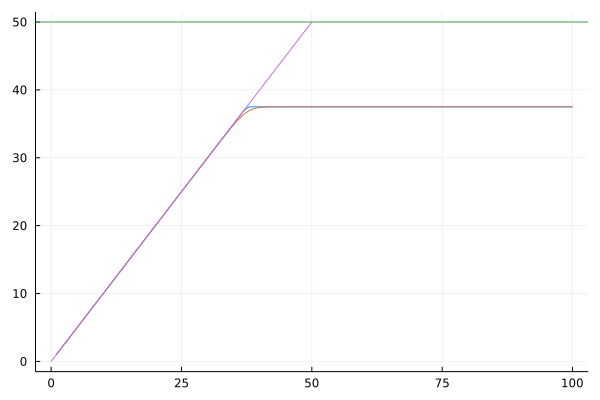

In [280]:
Plots.plot(1:100, broadcast(x -> convert_harvest.(50, x)[1], 1:100))
Plots.plot!(1:100, broadcast(x -> convert_harvest2.(50, x)[1], 1:100),legend = false)
Plots.hline!([50])
Plots.plot!([0,50],[0,50])

In [268]:
pars = [10.0, 100]
function Bt(x,Ht,pars)
    B = exp(x[1])
    epsilon = exp(x[2]) # production shocks

    H,B=convert_harvest(B, Ht)

    Bprime = (1+ 4*pars[1]/pars[2])*B - 4*pars[1]*B^2/pars[2]^2
    Bprime *= epsilon
    return [log(Bprime),0.0]
end 

function Bt!(x,Ht,pars) 
    B = exp(x[1])
    epsilon = exp(x[2]) # production shocks

    H,B=convert_harvest(B, Ht)
    
    Bprime = (1+ 4*pars[1]/pars[2])*B - 4*pars[1]*B^2/pars[2]^2
    Bprime *= epsilon
    x[1] = log(Bprime)
end 


T(x,Ht) = Bt(x,Ht,pars) 
T!(x,Ht) = Bt!(x,Ht,pars) 


function R_obs(x,Ht)
    B = exp(x[1])
    
    H,B=convert_harvest(B, Ht)
    
    return H
end

R(x,Ht,Ot) = R_obs(x,Ht)
H = [1.0 0.0]
Sigma_N = zeros(2,2)
Sigma_N[1,1] = 0.0001
Sigma_N[2,2] = 0.075


function Sigma_O(a, obs)
    Sigma_O = zeros(1,1)
    if obs == 3
        Sigma_O[1,1] = 0.01
    elseif obs == 2
        Sigma_O[1,1] = 0.05
    elseif obs == 1
        Sigma_O[1,1] = 0.1
    else
        Sigma_O[1,1] = 0.2
    end
    return Sigma_O
end 

Sigma_O (generic function with 1 method)

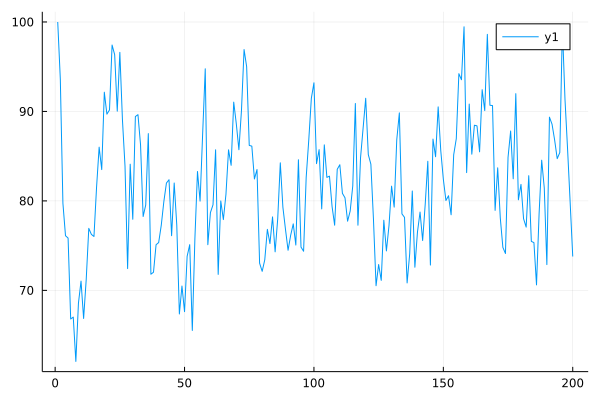

In [269]:
using Plots
using Distributions
x = [log(100.0),0.0]
B = zeros(200)
for i in 1:200
    B[i] = x[1]
    x = T(x,0.1*exp(x[1]))
    x[2] = rand(Distributions.Normal(0,Sigma_N[2,2]))
end 
    

Plots.plot(exp.(B))

In [458]:
delta= 1/(1+0.075)
actions = collect(2.5:5.0:102.5)
observations = [0,1]
lower_mu = [0.0]
upper_mu = [100.0]
dims_s_quad = 1

1

In [471]:
include("../src/BeleifMDPSolvers.jl")
include("../examples/SurplusProduction.jl")

sol = BeleifMDPSolvers.initSolver(SurplusProduction.T!,SurplusProduction.T,SurplusProduction.R,
            dims_s_quad,x -> 1,SurplusProduction.H,
            SurplusProduction.Sigma_N,
            SurplusProduction.Sigma_O,delta,actions,
            observations,lower_mu,upper_mu;n_grids_obs = 10,m_Quad_x=5,m_Quad_y=5)

print(" ")

In [472]:
BeleifMDPSolvers.solve_parallel!(sol; max_iter =10,tol = 0.0001)

0 100.01
1 79046.58975737958
2 25601.2388682033
3 11533.619054093113
4 5939.679362573322
5 3702.991642609772
6 2605.777959461886
7 1977.859486776495
8 1571.13735464926
9 1284.5063590764569


"Two stage VFI: full model failed"

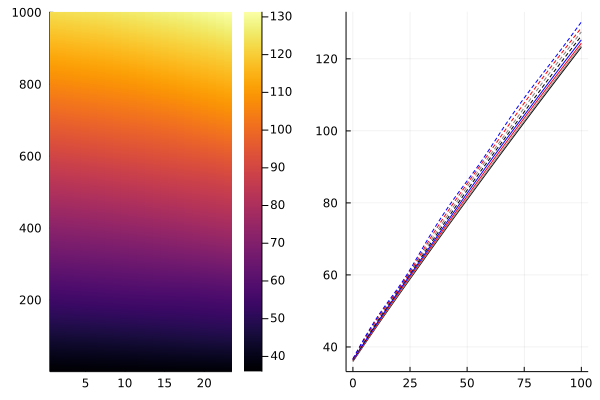

In [473]:
z = zeros(2)

mu = zeros(1)

mu_vals = (sol.valueFunction.lower_mu):0.1:(sol.valueFunction.upper_mu)
V_vals = 0.01:0.01:sol.valueFunction.upper_sigma


vals = zeros(length(mu_vals),length(V_vals))
Cov = zeros(1,1)
i=0
for x in mu_vals
    i+=1
    j = 0
    for V in V_vals
        j+=1
        Cov[1,1] = V
        mu[1] = log(x) - 0.5*V
        vals[i,j]=sol.valueFunction(zeros(2),(mu,Cov))
            
    end 
end 

p1=Plots.heatmap(vals)

p2=Plots.plot(mu_vals,vals[:,1], color = "black") 
Plots.plot!(mu_vals,vals[:,3], color = "grey")
Plots.plot!(mu_vals,vals[:,6], color = "red") 
Plots.plot!(mu_vals,vals[:,9], color = "blue") 
Plots.plot!(mu_vals,vals[:,12], color = "black", linestyle = :dash) 
Plots.plot!(mu_vals,vals[:,15], color = "grey", linestyle = :dash) 
Plots.plot!(mu_vals,vals[:,18], color = "red", linestyle = :dash) 
Plots.plot!(mu_vals,vals[:,21], color = "blue", linestyle = :dash, legend = false) 

plot(p1,p2)

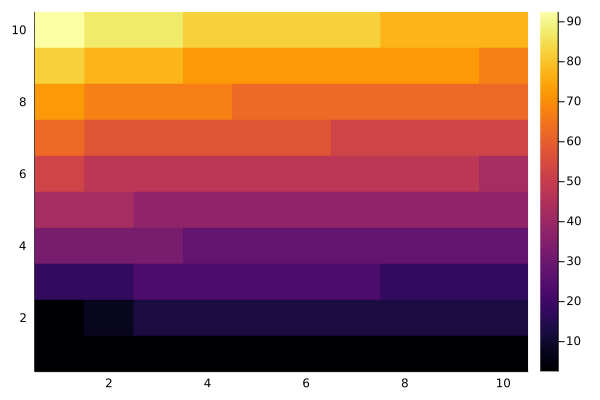

In [474]:

m = reshape(broadcast(x -> BeleifMDPSolvers.BellmanOpperators.Policy!(x,
                                    sol.bellmanIntermidiate[1],
                                    sol.valueFunction, 
                                    sol.POMDP,sol.optimizer)[1], BeleifMDPSolvers.augmented_nodes(sol)),10,10)
Plots.heatmap(m)

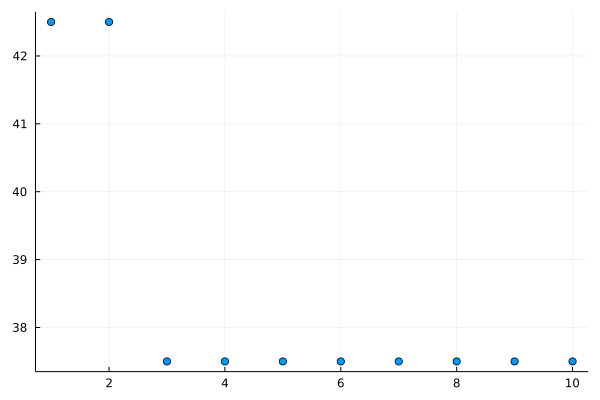

In [475]:
Plots.scatter(1:10,m[5,:], legend = false)

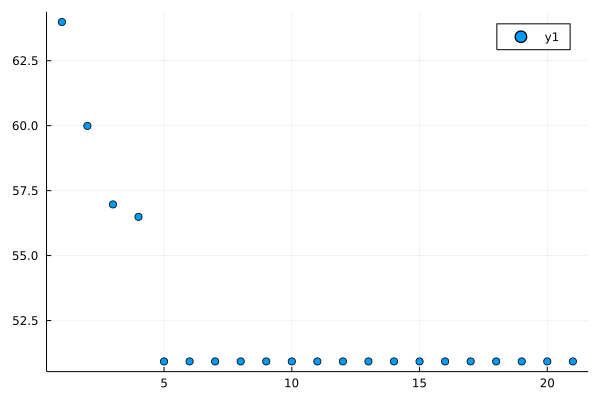

In [476]:
states = reshape(BeleifMDPSolvers.augmented_nodes(sol),10,10)

m = broadcast(x -> BeleifMDPSolvers.BellmanOpperators.value_expectation!(states[3,10],
                                    x,0, sol.bellmanIntermidiate[1], sol.POMDP, sol.valueFunction), actions)
Plots.scatter(m)

In [443]:
BeleifMDPSolvers.BellmanOpperators.value_expectation!(states[3,7],
                                    actions[3],0, sol.bellmanIntermidiate[1], sol.POMDP, sol.valueFunction)

20.309446940710338

In [440]:
sol.bellmanIntermidiate[1].x_cov

2×2 Matrix{Float64}:
 0.306518  0.0
 0.0       0.1

In [411]:
actions[16]

17.5

In [441]:
reshape(BeleifMDPSolvers.augmented_nodes(sol),10,10)[3,7]

([3.1441258248682007, 0.0], [0.14950000000000002 0.0; 0.0 0.1])

In [395]:
mu_vals = collect(sol.valueFunction.lower_mu:10.0:sol.valueFunction.upper_mu ).+ 0.01
V_vals = 0.01:0.025:sol.valueFunction.upper_sigma 

acc_H = zeros(length(mu_vals),length(V_vals))
acc_O = zeros(length(mu_vals),length(V_vals))
   
i = 0
Cov=zeros(2,2)
for a in mu_vals
    i+=1
    print(i, " ")
    for j in 1:length(V_vals)
        b = V_vals[j]
        Cov[1,1] = b
        Cov[2,2] = sol.POMDP.Sigma_N[2,2]

        mu = [log(a)-0.5*b,0.0]# #

        
        acc_H[i,j],acc_O[i,j] = BeleifMDPSolvers.BellmanOpperators.Policy!((mu,Cov),
                                    sol.bellmanIntermidiate[1],
                                    sol.valueFunction, 
                                    sol.POMDP,sol.optimizer)

    end 
end 


1 2 3 4 5 6 7 8 9 10 11 

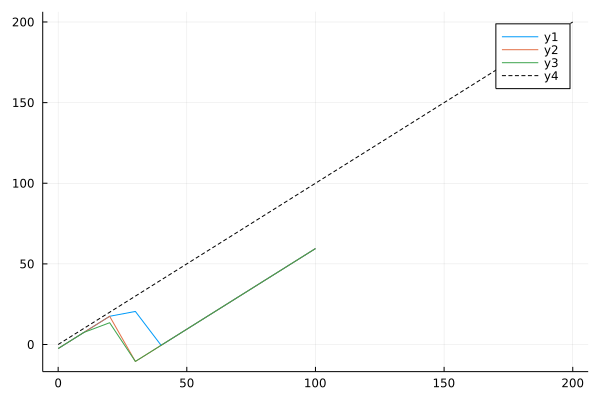

In [396]:
Plots.plot(mu_vals ,mu_vals.-acc_H[:,1])
Plots.plot!(mu_vals ,mu_vals.-acc_H[:,4])
Plots.plot!(mu_vals ,mu_vals.-acc_H[:,8])

Plots.plot!([0,200],[0,200], color = "black", linestyle=:dash)

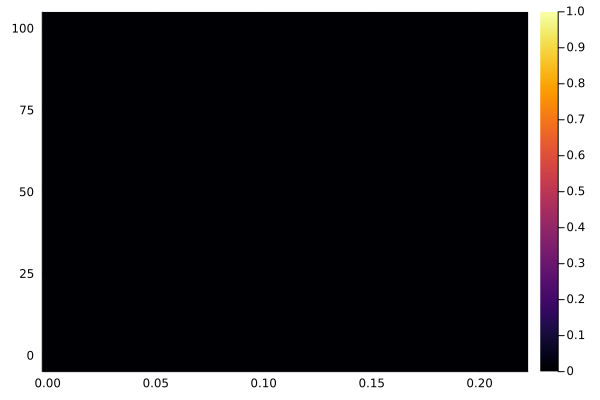

In [397]:

Plots.heatmap(V_vals,mu_vals,acc_O)

In [144]:
using JLD2
#@save "data/surplus_production_sol2.jld2" sol

In [ ]:
using KalmanFilters

In [ ]:
cov[1,1] = 0.3
cov[2,2] = sol.POMDP.Sigma_N[2,2]
a = 100
mu = [log(a),0.0]
Sigma_O(0,3)